# Speed benchmarks

In [1]:
import torch
from medusa.benchmark import FancyTimer
from medusa.detect import SCRFDetector, YunetDetector

torch.set_grad_enabled(False)

timer_ = FancyTimer()
params = {
    "model_cls": [SCRFDetector, YunetDetector],
    "device": ['cuda', "cpu"],
    "batch_size": [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
}

In [2]:
from medusa.data import get_example_image

for p in timer_.iter(params):

    if p["model_cls"] == YunetDetector and p["device"] == "cuda":
        continue

    model = p["model_cls"](device=p["device"])
    img = get_example_image(device=p["device"])
    img = img.repeat(p["batch_size"], 1, 1, 1)

    with torch.inference_mode():
        timer_.time(model, [img], n_warmup=3, repeats=20, params=p)

    torch.cuda.empty_cache()

df_detect = timer_.to_df()

100%|██████████| 40/40 [08:33<00:00, 12.83s/it]


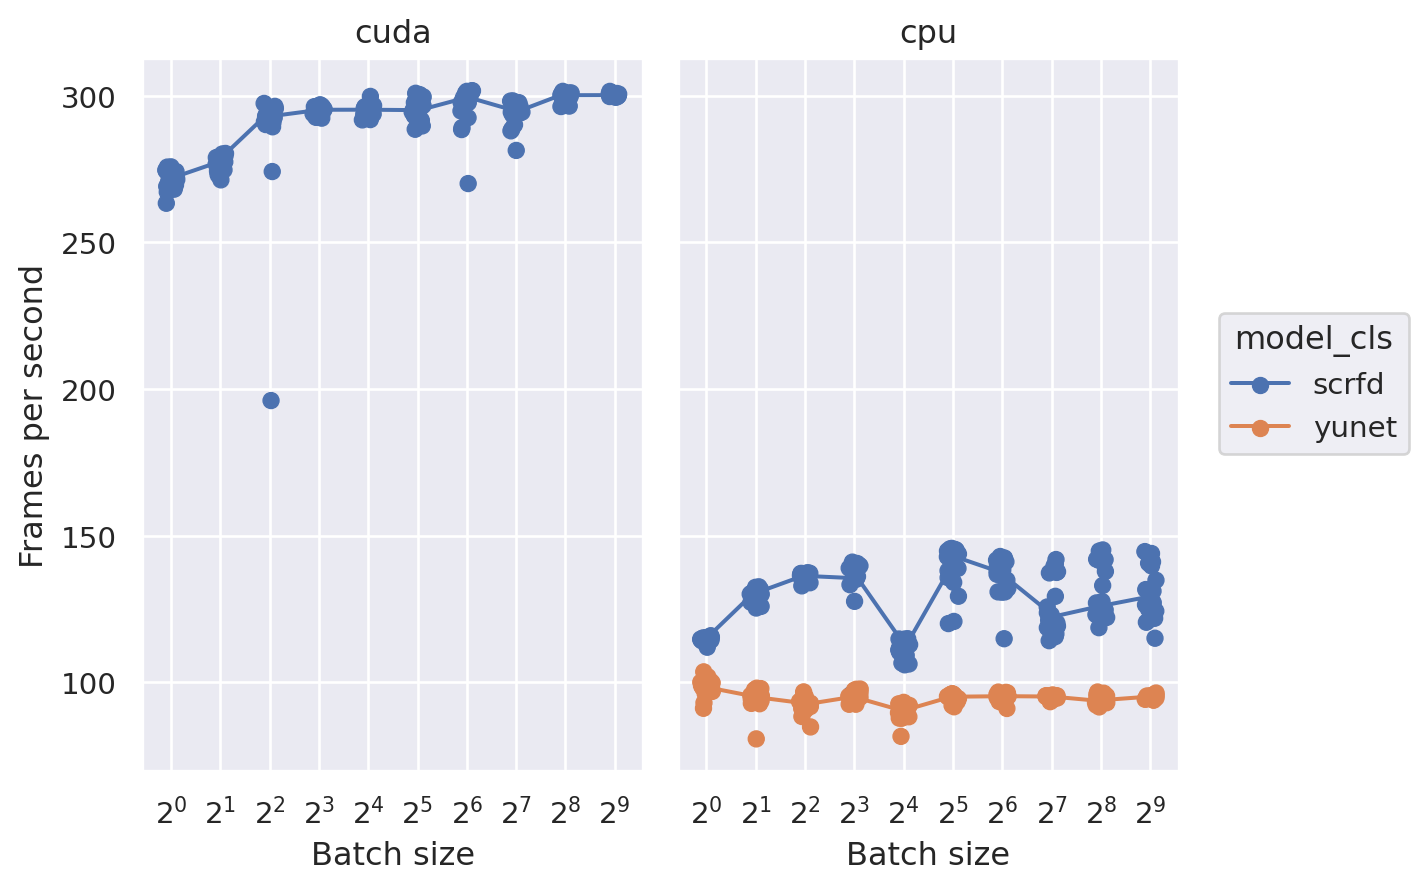

In [4]:
import seaborn.objects as so

df_detect['BPS'] = 1 / df_detect['duration']
df_detect['FPS'] = df_detect['BPS'] * df_detect['batch_size']

(
    so.Plot(df_detect, x='batch_size', y='FPS', color='model_cls')
    .facet(col="device")
    .share(y=True, x=True)
    .add(so.Dot(), so.Jitter(.3))
    .add(so.Line(), so.Est('median', errorbar='sd'), so.Jitter(.3))
    .scale(
        x=so.Continuous(trans="log2").tick(count=len(params['batch_size']), between=(1, max(params['batch_size']))),
        #y=so.Continuous(trans='log')
    )
    .label(
         x="Batch size", y="Frames per second"
    )
)

In [5]:
import torch
from medusa.recon import DecaReconModel

timer_ = FancyTimer()
params = {
    "device": ['cuda', "cpu"],
    "batch_size": [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
}

for p in timer_.iter(params):

    model = DecaReconModel(name='emoca-coarse', device=p["device"])
    img = get_example_image(device=p["device"])
    img = img.repeat(p["batch_size"], 1, 1, 1)
    with torch.inference_mode():
        timer_.time(model, [img], n_warmup=3, repeats=5, params=p)

    torch.cuda.empty_cache()

df_recon = timer_.to_df()

100%|██████████| 20/20 [04:54<00:00, 14.74s/it]


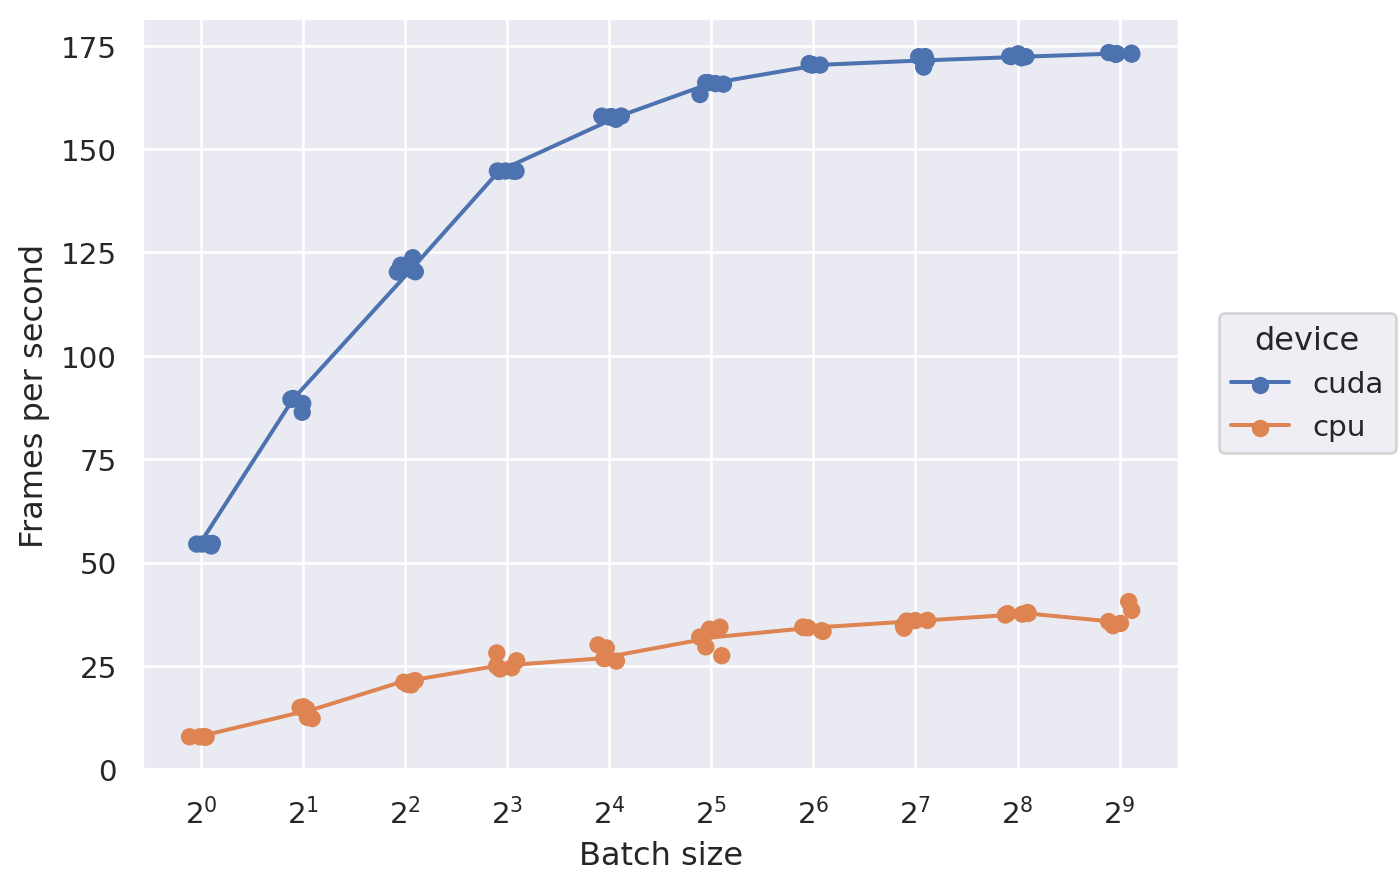

In [6]:
df_recon['BPS'] = 1 / df_recon['duration']
df_recon['FPS'] = df_recon['BPS'] * df_recon['batch_size']
(
    so.Plot(df_recon, x='batch_size', y='FPS', color='device')
    .add(so.Dot(), so.Jitter(.3))
    .add(so.Line(), so.Est('median', errorbar=('ci', 99.99)), so.Jitter(.3))
    .scale(
        x=so.Continuous(trans="log2").tick(count=len(params['batch_size']), between=(1, max(params['batch_size']))),
    )
    .label(
         x="Batch size", y="Frames per second"
    )
)